### Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift

### Sergey Ioffe, Christian Szegedy from Google Inc.

### `정리`

### __Intro__

본 논문에서는 input 의 분포가 훈련을 진행하면서 바뀌게 되고, 분포가 바뀌게 되는 것을 ICS(Internal covariate shift) 이라하며, 

ICS의 문제를 해결하기 위한 방법으로 __Batch-Normalization(BN)__ 을 제안하고 있고, BN 을 사용했을 때의 성능들을 수치화하여 소개하고 있습니다.

### ICS (Internal Covariate Shift) 의 문제.

인풋 데이터가 히든레이어를 거치면서 분포가 변하게되고, 계속해서 변하는 분포에 대해서 학습하게 됩니다.

이로 인해 계속해서 변화하는 분포들로 인해 학습력,학습속도가 매우 떨어지게되고, 역전파 시 파라미터 갱신또한 매우 신중하게 되는 현상을 ICS 라고 말하고 있습니다.

본 논문에서는 `makes it notoriously hard to train` 라고 표현하고 있습니다. 

### What is `BN` ??

BN 은 batch_size 단위의 평균, 분산과 batch_size 단위의 개별 변량들에 대해서 normalize 하는 것이라고 소개하고 있고,

같은 정확도를 산출함에 있어서 training_step 이 기존 대비 14번이 낮게 나왔고 성능또한 더 좋았다라고 말하고 있습니다.

BN 의 pros and cons

### `pros`

1. 변량끼리의 독립적이지 않음(다중 공선성)에도 학습을 잘 하더라.

2. 학습률을 다소 높여도 된다.

3. regularizer, dropout 이 필요없다.

4. 가중치 초기화에 덜 민감하다.

5. 기울기 소실 개선.

### `cons`

1. batch_size 에 의존적이다.

2. rnn 에 사용 불가.

BN 의 식은 아래와 같습니다.

all_data = 640, batch_size = 32 라 가정. 

$B_n = x_i(x_1, x_2, ...., x_{32})$ `20 개`

mean = $\mu_{B_n} = \frac{1}{32}\sum_{i=1}{x_i} $ `20 개`

variance = $(\sigma_{B})^2 = \frac{1}{32}\sum_{i=1}({x_i - \mu_{B_n}})^2$ `20 개` 

__normalize__ = $\hat{x_i} = \frac{{x_i - \mu_{B_n}}}{\sqrt{(\sigma_{B})^2 + \epsilon}}$ `20 개`

__normalize__ 시 분포의 평균과 분산이 0, 1이 되게끔 해준다. 이 때 분포가 가우시안이 아니여도 상관 없음.

<img src = 'https://drive.google.com/uc?id=1Zug_UV1jGZiDoPzm3jIHGVD8geH_L5Lu' width = 700, height = 400>


sigmoid 같은 경우 normalize 를 하지 않았다면 기울기가 살아나는 빨간 점들(정의역) 바깥에서 

기울기가 거의 없었을 상황을 해결하게된다.

이 때 "비선형이여야 좋은데, 너무 선형적이 되는 것 같다. 애초에 sigmoid 가 비선형 값 얻으려고한 거 아니였냐" 는 문제를

scaling and shift 로 해결한다.

<img src = 'https://drive.google.com/uc?id=1lK21paQLo63P-3Xh-MYtxhszKeYWZ05P' width = 700 height = 400>

일단 분포를 $(0, 1^2)$ 하게 모으고, 그 정도를 $\gamma, \beta$ 로 조절한다.

이로 인해 기울기도 살리고 선형적이게 되는 문제도 어느정도 해소하는 것이

scale and shift 이다.

scale and shift = $y_i = \gamma \times \hat{x_i} +  \beta$ `20 개`

normalize 된 분포를 scaling 하고 shift 한다.

이로 인해 발생한 $\gamma, \beta$ 에 대해서는 본 논문에서 

restore the representation power of the network. 라고 표현하고 있다.

이 문장에 대해서는 __"학습할 파라미터가 많아져서 분산이 올라가는 것을 인정하지만, 다시 표현력을 회복할 것이다".__ 라고 해석했다.

training 시 각 데이터들의 통계치를 기반으로 update 하고

test 시는 mean, variance 에 대한 20개의 평균으로 계속 update 한다.

`note` $E(variance)$ 는 모 분산을 나타내지 않는다.

$E(variance)$ 를 계산해보면 $\frac{(m-1)\times(\sigma_{모표준편차})^2}{m}$ 이렇게 나오게 되는데

이 때 값을 보정해주기 위해 $E(variance) \times \frac{m}{m-1}$ 하게된다.

아마 애초에 $(\sigma_{B})^2 = \frac{1}{31}\sum_{i=1}({x_i - \mu_{B_n}})^2$ 하지 않은 이유는

bias 를 고려하지 않는 unbias estimate 이기 때문에 bias 를 고려한 bias estimate 방식이 training 할 때

성능이 더 좋았기 때문이 아닐까 생각한다. 왜냐하면 결국 loss 를 계산할 때 기울기가 딱 맞아 떨어지더라도

위 아래 평행이동을 하며 계속해서 bias 를 수정하지 않는다면 여전히 오차는 남아있기 때문이 아니였을까.

원래 표본의 분산은 m이 아닌 m-1로 나누어준다는 고등학교 확률과 통계 과목에서 배운 내용에서 생각해보면

고등학교 수학은 unbias 한 방법을 선택한 것을 알려준 거라는 걸 깨달았다 !

구현한 코드는 아래와 같다.

layers.Dense(32),

layers.BatchNormalization(),

layers.Activation('relu'),

layers.Dense(16),

layers.BatchNormalization(),

layers.Activation('relu'),

layers.Dense(8),

layers.BatchNormalization(),

layers.Activation('relu')])

이런 식으로 Dense 층 에서 가중 합을 구하고,

그 가중 합을 BN 하고

그 BN 값을 활성화 함수에 넣는 방식이다.

식으로 표현하면 

x = input

Z = Wx + b -> BN(Z)

a(BN(Z)) 라고 할 수 있겠다.

층이 깊어짐에 따라 Z 값이 $Wa^L + b_i$ 가 된다는 점을 참고. ($a^L$ 은 L 번째의 활성화 값을 의미)

Batch Normalization 의 성능을 확인해보면 아래와 같습니다.

### `batch normalize 전`

![](2022-11-26-11-29-50.png)

### `batch normalize 후`

![](2022-11-26-11-29-15.png)

### __분포의 변화 과정으로 마무리 하겠습니다.__

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import BatchNormalization

In [7]:
imga = plt.imread("a.jpg")
imgb = plt.imread("b.jpg")
imgc = plt.imread("c.jpg")

In [9]:
imgs = np.zeros((3, ) + imga.shape)

# 이미지 normalize 0 ~ 1 
imgs[0] = imga/255.0
imgs[1] = imgb/255.0
imgs[2] = imgc/255.0
print(imga.shape)

(1440, 1080, 3)


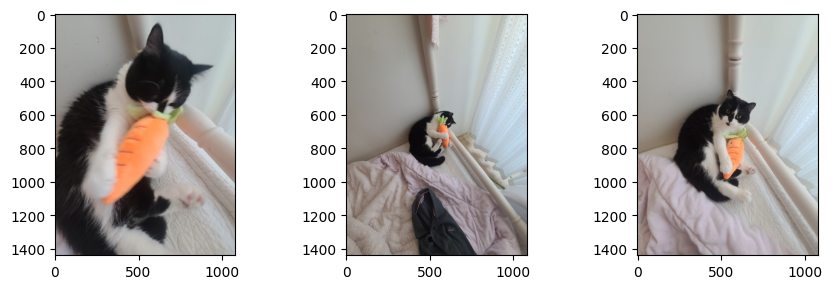

In [10]:
def plot_img(imgs):
    '''이미지가 그림으로 산출되기 어려운 값이 안되게 minmax scale'''
    if imgs.min() < 0:
        imgs = imgs - imgs.min()
    if imgs.max() > 1:
        imgs = imgs/imgs.max()
    
    fig, axs = plt.subplots(ncols=len(imgs), figsize=(3*len(imgs), 3))
    for img, ax in zip(imgs, axs):
        ax.imshow(img)

    fig.tight_layout()    
    return fig

fig = plot_img(imgs)

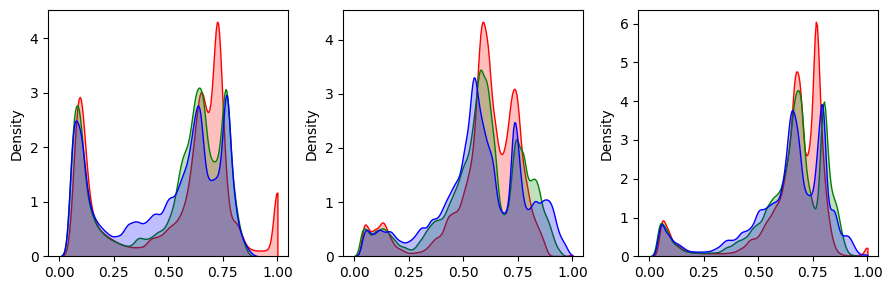

In [12]:
def plot_kde(imgs, symmetry = False):

    fig, axs = plt.subplots(ncols=len(imgs), figsize=(3*len(imgs), 3), sharex=True)

    for img, ax in zip(imgs, axs):
        channel = [0, 1, 2]
        color = ["r", "g", "b"] 
        [sns.kdeplot(img[:,:,ch].flatten(), color=c, fill=True, ax=ax, cut=0) for ch, c in zip(channel, color)]

    xlim = ax.get_xlim()

    if symmetry==True:
        xlim = [-max(abs(xlim)), max(abs(xlim))]
        axs[0].set_xlim(xlim)
    
    fig.tight_layout()
    return fig, axs

fig, axs = plot_kde(imgs)

### 분포들에 집중하세요 ! 

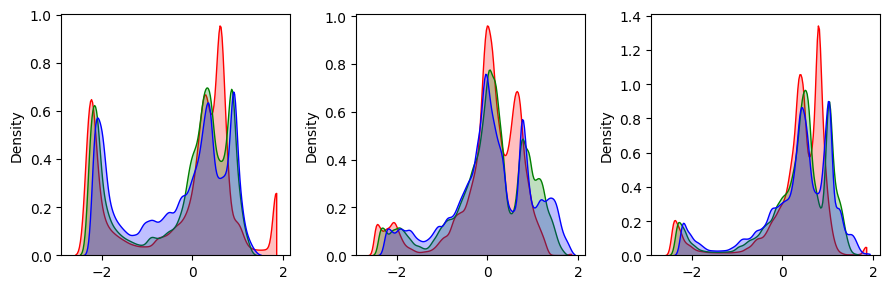

In [16]:
imgs_tensor = tf.convert_to_tensor(imgs, dtype="float32")

model = Sequential()
model.add(BatchNormalization())
model.compile()

hist = model(imgs_tensor, training=True)

picpy = hist.numpy()
fig2, _ = plot_kde(picpy)

### Batch Normalization 전과 비교했을 때 0 쪽으로 분포가 shift 된 모습

![](2022-11-26-15-21-46.png)

![](2022-11-26-15-22-18.png)

Batch Normalization 전

In [22]:
imgs[0].mean(), imgs[1].mean(), imgs[2].mean()

(0.5100027611353182, 0.5792291557397992, 0.6341450760173747)

In [21]:
imgs[0].var(), imgs[1].var(), imgs[2].var()

(0.06814524717261809, 0.03811301116959442, 0.03687588800838527)

Batch Normalization 후

In [35]:
model.layers[0].variables[2].numpy() # 평균

array([0.00589771, 0.00569297, 0.00558178], dtype=float32)

In [36]:
model.layers[0].variables[3].numpy() # 분산

array([0.9904824, 0.9904975, 0.9905175], dtype=float32)